In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.stats import binned_binom_proportion
from astropy.wcs import WCS
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from m33_utils import open_and_select

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

A star was considered to be recovered if it was detected within two pixels of the same position, passed our quality criteria, and had a measured magnitude within 2 mag of the input value.

In [2]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None,
                 offset=0.0175, width=0.0225, label='Density'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

def read_artstars(infile):
    ds = open_and_select(infile)
    ds['DPOS'] = ds['((X_OUT-X_IN)**2 + (Y_OUT-Y_IN)**2)**0.5']
    for f in ds.get_column_names(regex='F.*?W_IN'):
        filt = f.split('_')[0]
        ds.add_column(f'{filt}_DELTA', ds[f'{filt}_VEGA-{filt}_IN'].evaluate())
        selection = f'({filt}_GST) & (DPOS < 2) & (abs({filt}_DELTA) < 2)'
        is_detected = ds.evaluate_selection_mask(selection).astype(int)
        ds.add_column(f'{filt}_DET', is_detected)
    return ds


def plot_completeness(ds, x0=17.875, x1=30.125, n=50):
    x = np.linspace(x0, x1, n)
    df_comp = pd.DataFrame(data=(x[:-1]+x[1:])/2, columns=['mag']).set_index('mag', drop=True)
    with sns.color_palette(sns.hls_palette(6, l=0.5)[::-1]):
        handles = []
        labels = ['F275W','F336W','F475W','F814W','F110W','F160W']
        fig, ax = plt.subplots(1, figsize=(6, 4))
        for i,c in enumerate(labels):
            comp_col = f'{c} 50% completeness'
            vals = ds[f'{c}_IN'].values
            succ = ds[f'{c}_DET'].values
            if c == 'F275W':
                good = vals < 28.75
                succ = succ[good]
                vals = vals[good]
            bc, hw, p, perr = binned_binom_proportion(vals, succ, bins=x,
                                                      confidence_level=0.95,
                                                      interval='jeffreys')
            ptch = ax.fill_between(bc, p-perr[0], p+perr[1], alpha=0.3, zorder=-1)
            li, = ax.plot(bc, p, zorder=69-i)
            df_comp.loc[bc, comp_col] = p 
            df_comp.loc[bc, f'{c}_lo'] = perr[0] 
            df_comp.loc[bc, f'{c}_hi'] = perr[1] 
            s_interp = df_comp[comp_col].sort_values()
            c_interp = np.interp(0.5, s_interp.values, s_interp.index.values)
            df_comp.loc[c_interp, comp_col] = 0.5
            handles.append((ptch, li))
    #df_comp.sort_index().interpolate()
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(x0-0.5, x1+0.5)
    ax.axhline(0.5, color='k',ls='--')
    ax.legend(handles, labels, handlelength=1, loc='lower left',
              handler_map={tuple: HandlerTuple(ndivide=1)})
    ax.set_xlabel('Apparent magnitude (Vega)')
    ax.set_ylabel('Completeness fraction')
    return fig, ax, df_comp.sort_index().interpolate()

['../artstars/M33_B01_NN_fake_cor.hdf5', '../artstars/M33_B01_SS_fake_cor.hdf5', '../artstars/M33_B02_NN_fake_cor.hdf5', '../artstars/M33_B02_SS_fake_cor.hdf5']
(0, 0.15)
F275W 50% completeness    24.47
F336W 50% completeness    25.50
F475W 50% completeness    27.87
F814W 50% completeness    26.93
F110W 50% completeness    25.29
F160W 50% completeness    24.72
(0.15, 0.3)
F275W 50% completeness    24.47
F336W 50% completeness    25.23
F475W 50% completeness    27.64
F814W 50% completeness    26.70
F110W 50% completeness    24.80
F160W 50% completeness    24.30
(0.3, 0.6)
F275W 50% completeness    24.45
F336W 50% completeness    25.19
F475W 50% completeness    27.45
F814W 50% completeness    26.50
F110W 50% completeness    24.45
F160W 50% completeness    23.87
(0.6,)
F275W 50% completeness    24.35
F336W 50% completeness    24.36
F475W 50% completeness    26.52
F814W 50% completeness    25.63
F110W 50% completeness    23.45
F160W 50% completeness    22.82


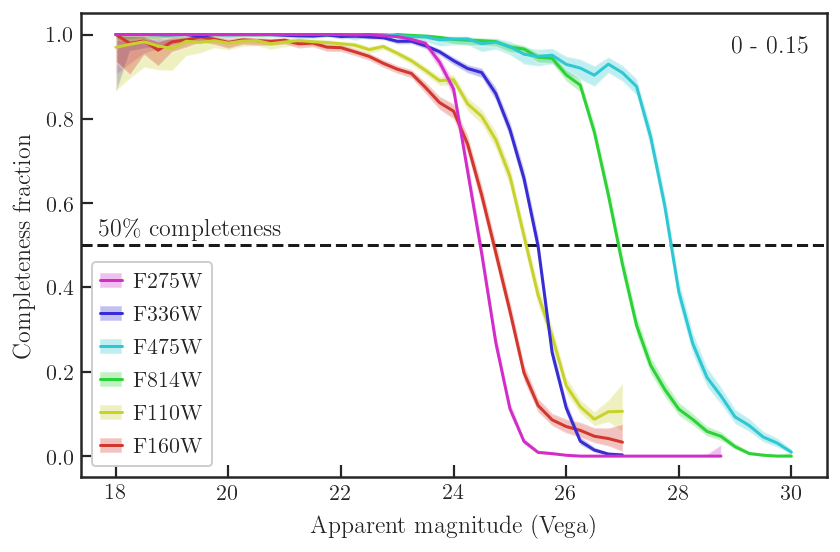

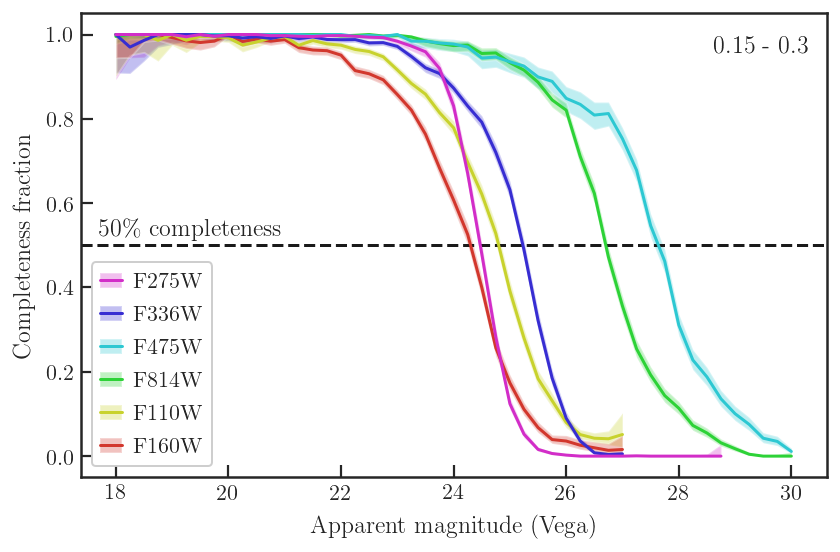

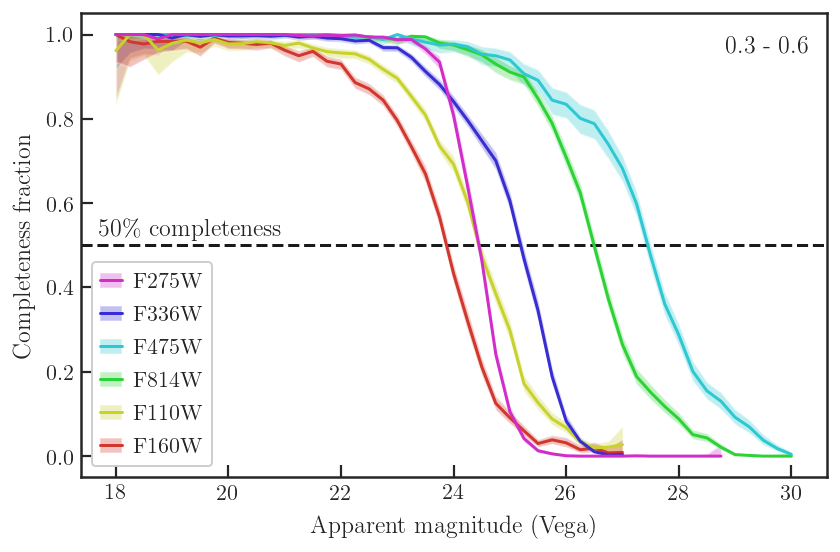

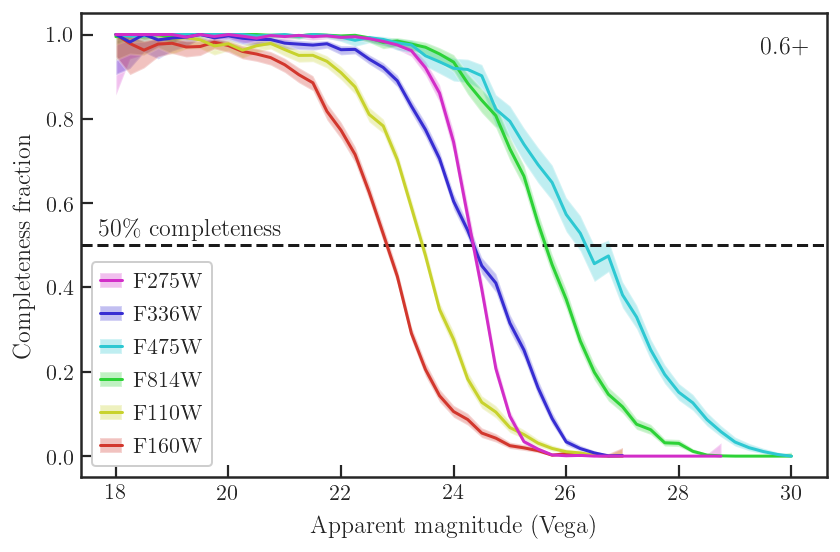

In [3]:
infiles = glob.glob('../artstars/M33_B0[1-2]_??_fake_cor.hdf5')
print(infiles)
densities = [(0, 0.15), (0.15, 0.3), (0.3, 0.6), (0.6,)]

for infile, density in zip(infiles, densities):
    ds = read_artstars(infile)
    fig, ax, comp = plot_completeness(ds)
    print(density)
    for f in ['F275W','F336W','F475W','F814W','F110W','F160W']:
        p50_idx = (comp[f'{f} 50% completeness'] - 0.5).abs().idxmin()
        lo, hi = comp.loc[p50_idx, [f'{f}_lo', f'{f}_hi']].values
        print(f'{f} 50% completeness    {p50_idx:.2f}') # +{hi:.2f}-{lo:.2f}
    txt = f'{density[0]} - {density[1]}' if len(density) == 2 else f'{density[0]}+'
    ax.text(0.975, 0.95, txt, va='top', ha='right', transform=ax.transAxes)
    ax.text(0.025, 0.51, '50\% completeness', va='bottom', ha='left', transform=ax.transAxes)
    name = infile.split('/')[-1].replace('_fake_cor.hdf5', '_comp.pdf')
    fig.tight_layout()
    fig.savefig(f'survey_paper_figures/{name}', bbox_inches='tight')

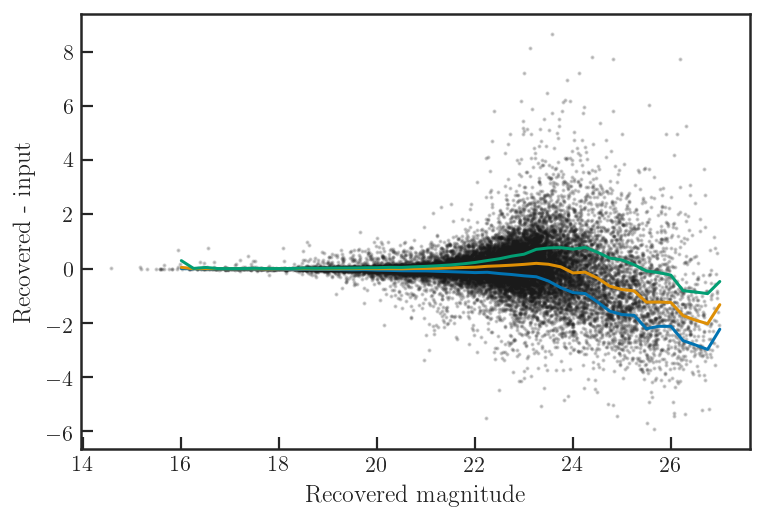

In [7]:
shape_kwargs = dict(limits=[15.875, 30.125], shape=57)
ds.scatter('F160W_IN','F160W_DELTA', s=1, color='k', alpha=0.2,
           xlabel='Recovered magnitude', ylabel='Recovered - input')
bc = ds.bin_centers('F160W_IN', **shape_kwargs)
p25, p50, p75 = ds.percentile_approx('F160W_DELTA', [25, 50, 75], 
                                binby='F160W_IN', **shape_kwargs)
plt.plot(bc, p25)
plt.plot(bc, p50)
plt.plot(bc, p75)

In [5]:
ds_all = read_artstars('../artstars/fake_combined.hdf5')

(5.0, -5.0)

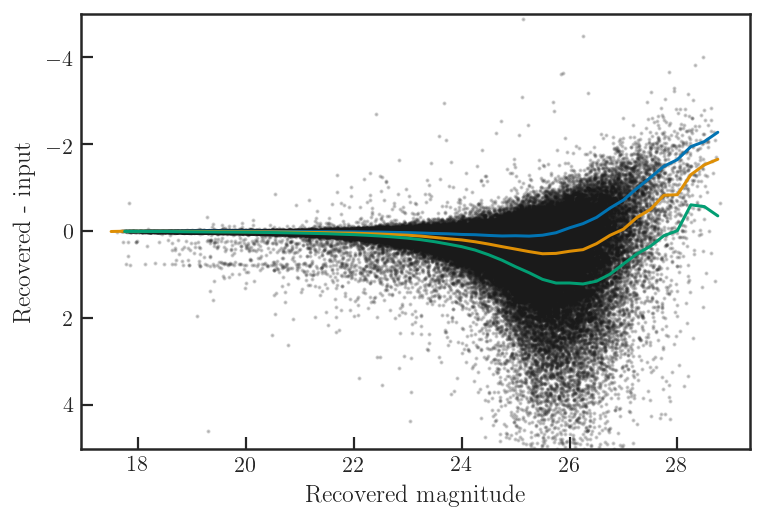

In [9]:
ds_all.scatter('F275W_IN','F275W_DELTA', s=1, color='k', alpha=0.2, 
           xlabel='Recovered magnitude', ylabel='Recovered - input', length_check=False)
bc = ds_all.bin_centers('F275W_IN', **shape_kwargs)
p25, p50, p75 = ds_all.percentile_approx('F275W_DELTA', [25, 50, 75], 
                                binby='F275W_IN', **shape_kwargs)
plt.plot(bc, p25)
plt.plot(bc, p50)
plt.plot(bc, p75)
plt.ylim(5,-5)